---
# Part 1, Figure 6
2018 cargo transfers to (import) and from (export) Washington state marine terminals, by cargo vessel type and volume

---

Package requirements are included in ../environment.yaml.  Install in the upper-level directory using:
```
$ conda env create -f ./environment.yaml
```
                                                                               
To activate this environment, use 
```                  
$ conda activate midoss_env
```
 To deactivate an active environment, use
```
$ conda deactivate
```

Files are loaded from the dataset archive, with both the dataset archive and this code archive in the same folder, i.e.:

- \path\to\root\folder\
   - MuellerEtAl_MIDOSS_datasets
   - MuellerEtAl_MIDOSS_code [this repository]


In [1]:
import pandas as pd
import numpy as np
import xarray
from pathlib import Path
import yaml
import os
import cmocean.cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# load my function(s) and setup files
import sys
# graphics style
plt.style.use(r"../style_templates/MuellerEtAl_matplotlibrc.template")
# predefined naming conventions
import manuscript_setup as oil
sys.path.insert(0, '../scripts')
from monte_carlo_utils import get_ECY_quantity_byfac, get_ECY_df, get_ECY_oilclassification, assign_facility_region

# conversion factor
gal2liter = 3.78541

In [2]:
graphics_directory = Path('../')
spreadsheet_directory = Path('../../MuellerEtAl_MIDOSS_datasets/spreadsheets')
yaml_input = Path('../../MuellerEtAl_MIDOSS_datasets/oil_attribution_yaml_files')
ecy_data  = spreadsheet_directory/'MuellerTrans4-30-20.xlsx'
fac_names = spreadsheet_directory/'Oil_Transfer_Facilities.xlsx'
    
# open oil_attribution.yaml for paths
oil_attribution_file = yaml_input / 'oil_attribution.yaml'
with open(oil_attribution_file) as file:
            oil_attrs = yaml.load(file, Loader=yaml.Loader) 

In [3]:
# define vessel and oil types to include in .yaml file
vessel_types = ['atb', 'barge', 'tanker']
oil_types    = oil.types
data_types    = ['total_gallons', 'fraction_of_total', 'number_of_transfers']

### Plot imports and exports by vessel type (in liters)

In [4]:
[exports, imports, combined]=get_ECY_quantity_byfac(
    ecy_data, 
    fac_names,  
    facilities='selected'
)

get_ECY_quantity_byfac: not yet tested with fac_xls as input
Tallying atb quantities
Tallying barge quantities
Tallying tanker quantities


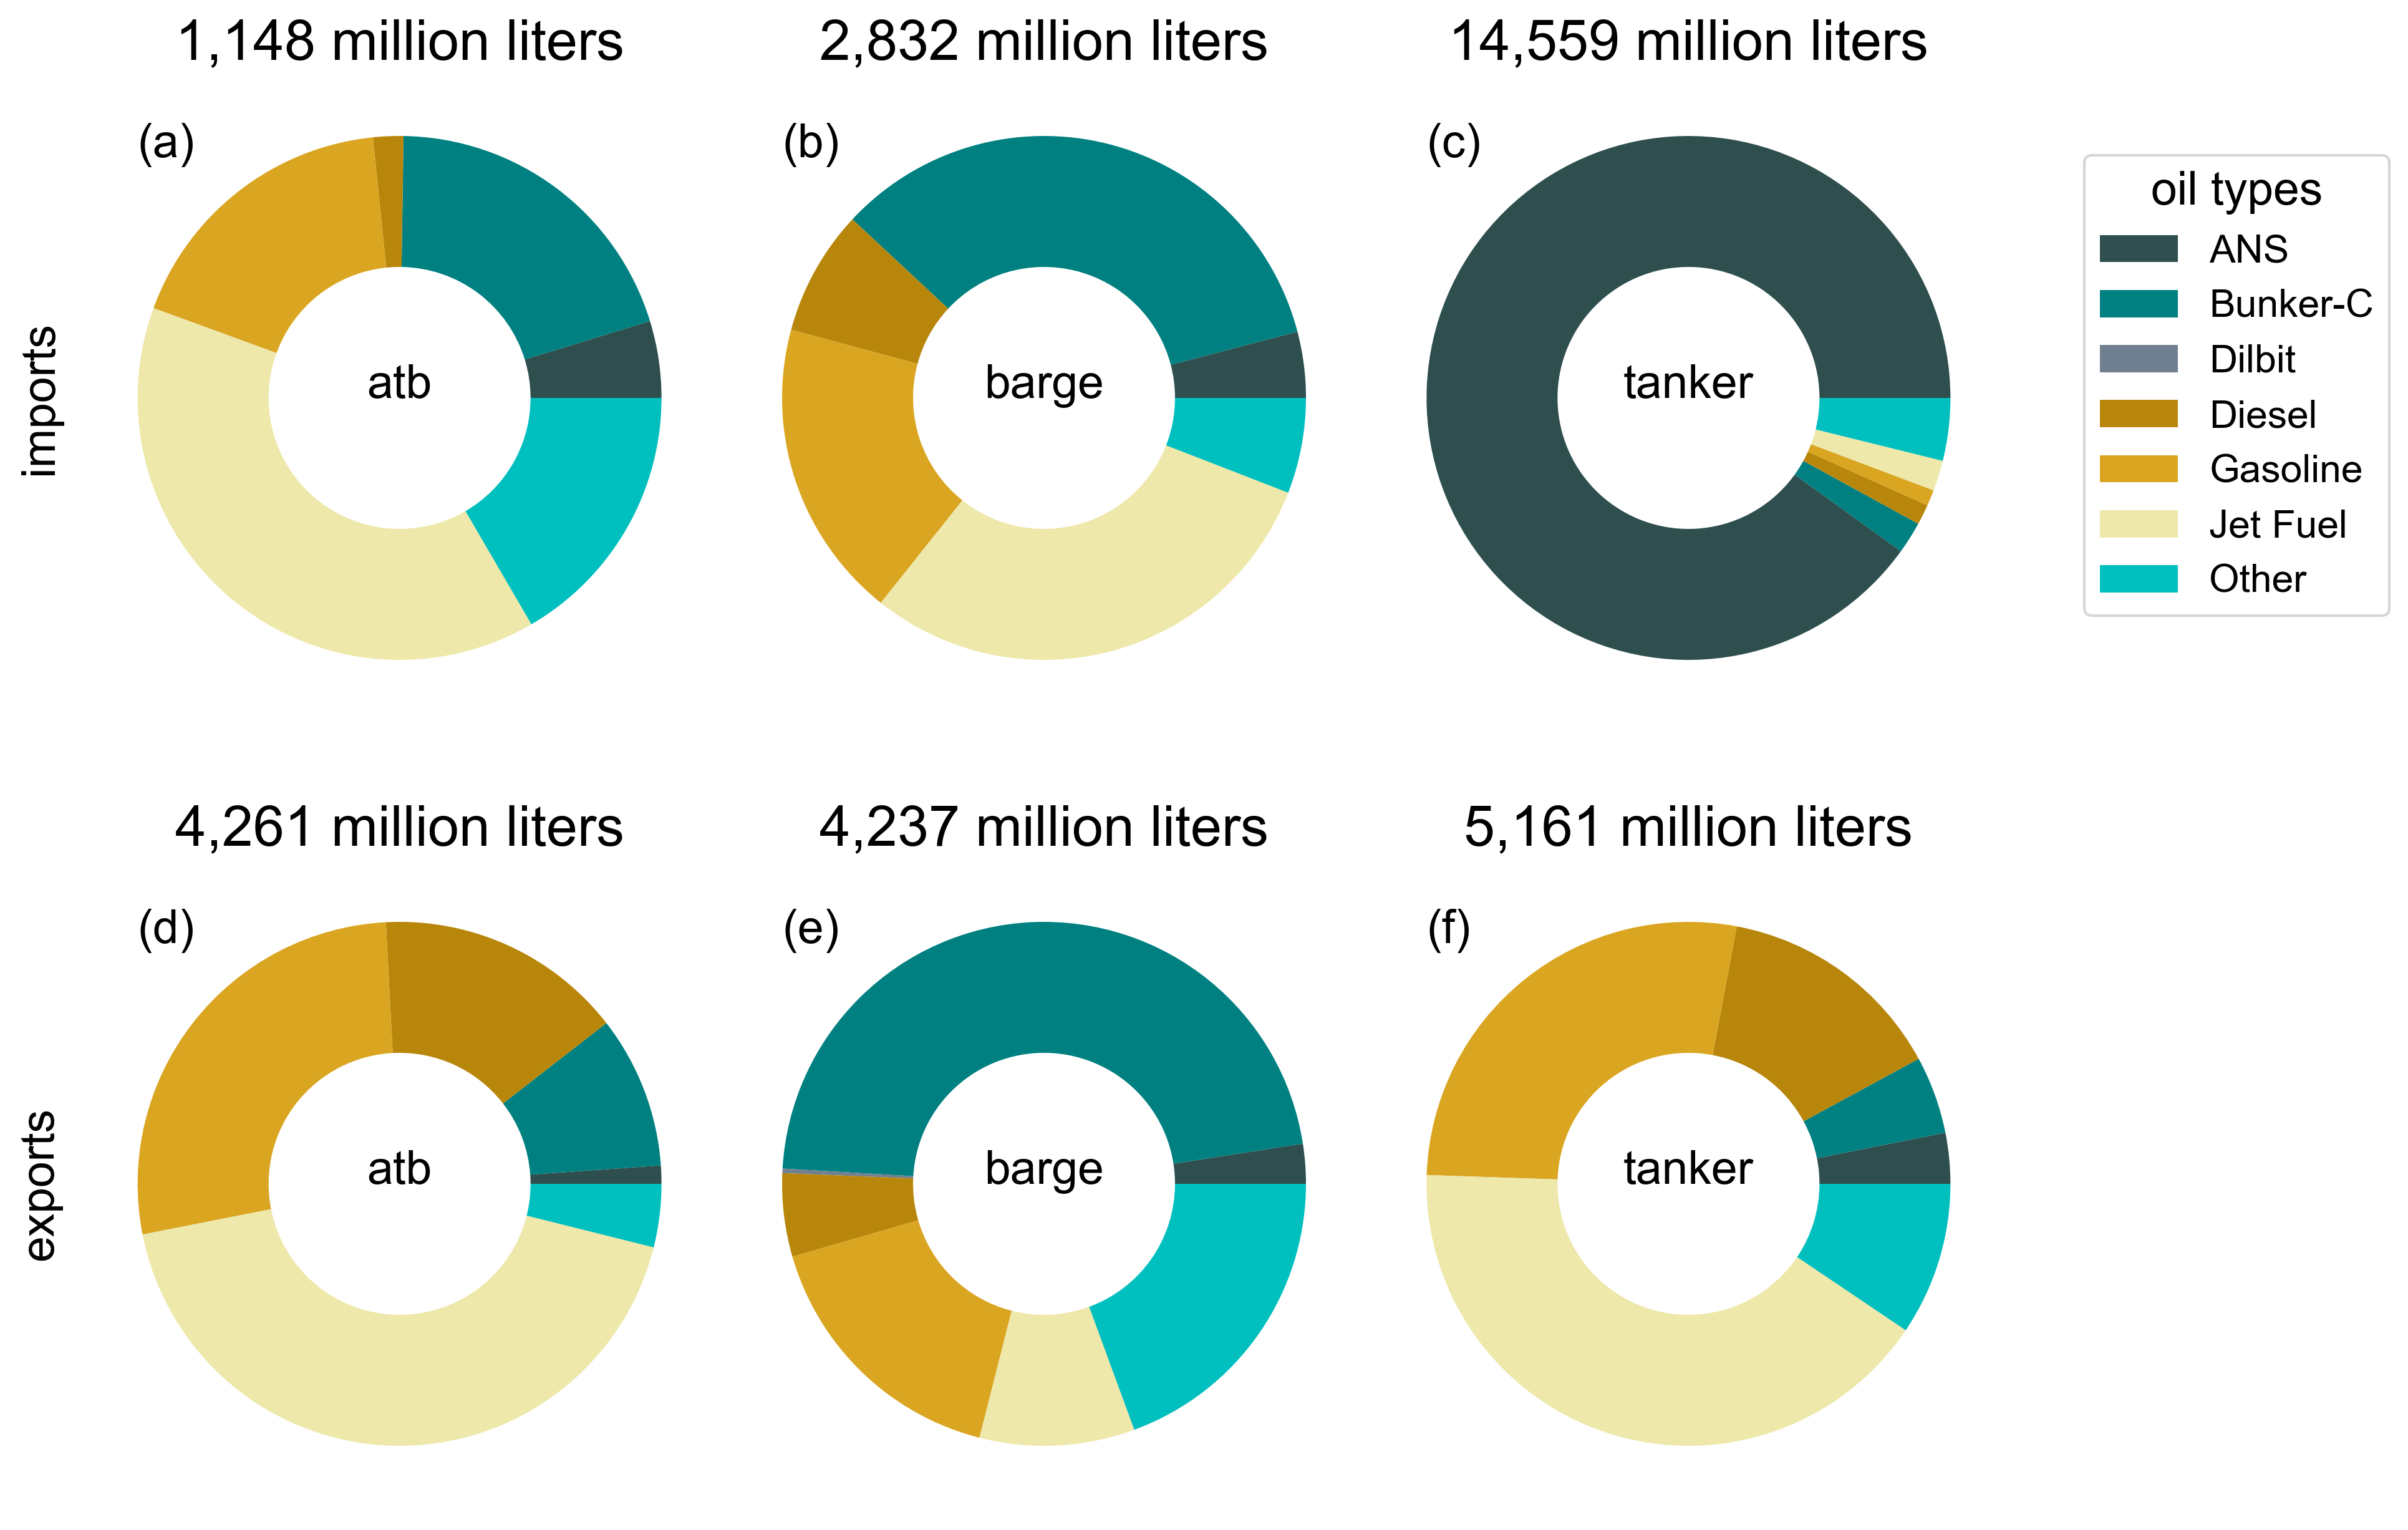

In [5]:
nc=3 #number of columns
fig = plt.figure()
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(10)
# set width of each subplot as 8
fig.set_figwidth(20)
fig.tight_layout
# create grid for different subplots
spec = gridspec.GridSpec(ncols=nc, nrows=2,wspace=-.6,
                         hspace=0.2,width_ratios=np.ones(nc),
                         height_ratios=[1,1])
ax={}
for ind in np.arange(nc*2):
    ax[ind] = fig.add_subplot(spec[ind])

plt.rcParams['axes.titlepad'] = -18  # pad is in points...

for j,vessel in enumerate(vessel_types):
            
    ax[j].axis('tight')
    ax[j+nc].axis('tight')
    
    # create array of total oil volume by oil type for each vessel at each facility
    plot_imports=np.array([v for v in imports[vessel].values()])
    plot_exports=np.array([v for v in exports[vessel].values()])
    # imports
    ax[j].pie(
        plot_imports, 
        wedgeprops=dict(width=0.5), 
        labels = None,
        colors=oil.colors7
    )
    # exports
    ax[j+nc].pie(
        plot_exports, 
        wedgeprops=dict(width=0.5), 
        labels = None,
        colors=oil.colors7
    )
    
    vessel = vessel_types[j]
    ax[j].set_title(f'{gal2liter*plot_imports.sum()/1e6:,.0f} million liters')
    ax[j+nc].set_title(f'{gal2liter*plot_exports.sum()/1e6:,.0f} million liters')
    ax[j].text(0,0,vessel,ha='center')
    ax[j+nc].text(0,0,vessel,ha='center')
           
ax[0].set_ylabel('imports')
ax[nc].set_ylabel('exports')
ax[0].text(-1,0.92,'(a)')
ax[1].text(-1,0.92,'(b)')
ax[2].text(-1,0.92,'(c)')
ax[nc].text(-1,0.92,'(d)')
ax[nc+1].text(-1,0.92,'(e)')
ax[nc+2].text(-1,0.92,'(f)')
ax[2].legend(
    bbox_to_anchor=(1.6, 0.9),
    title='oil types',
    labels = oil.labels
)
plt.savefig(graphics_directory/'Part1_Figure6a_oil_distribution_liters.png')


# Plot imports and exports by vessel type (in gallons)

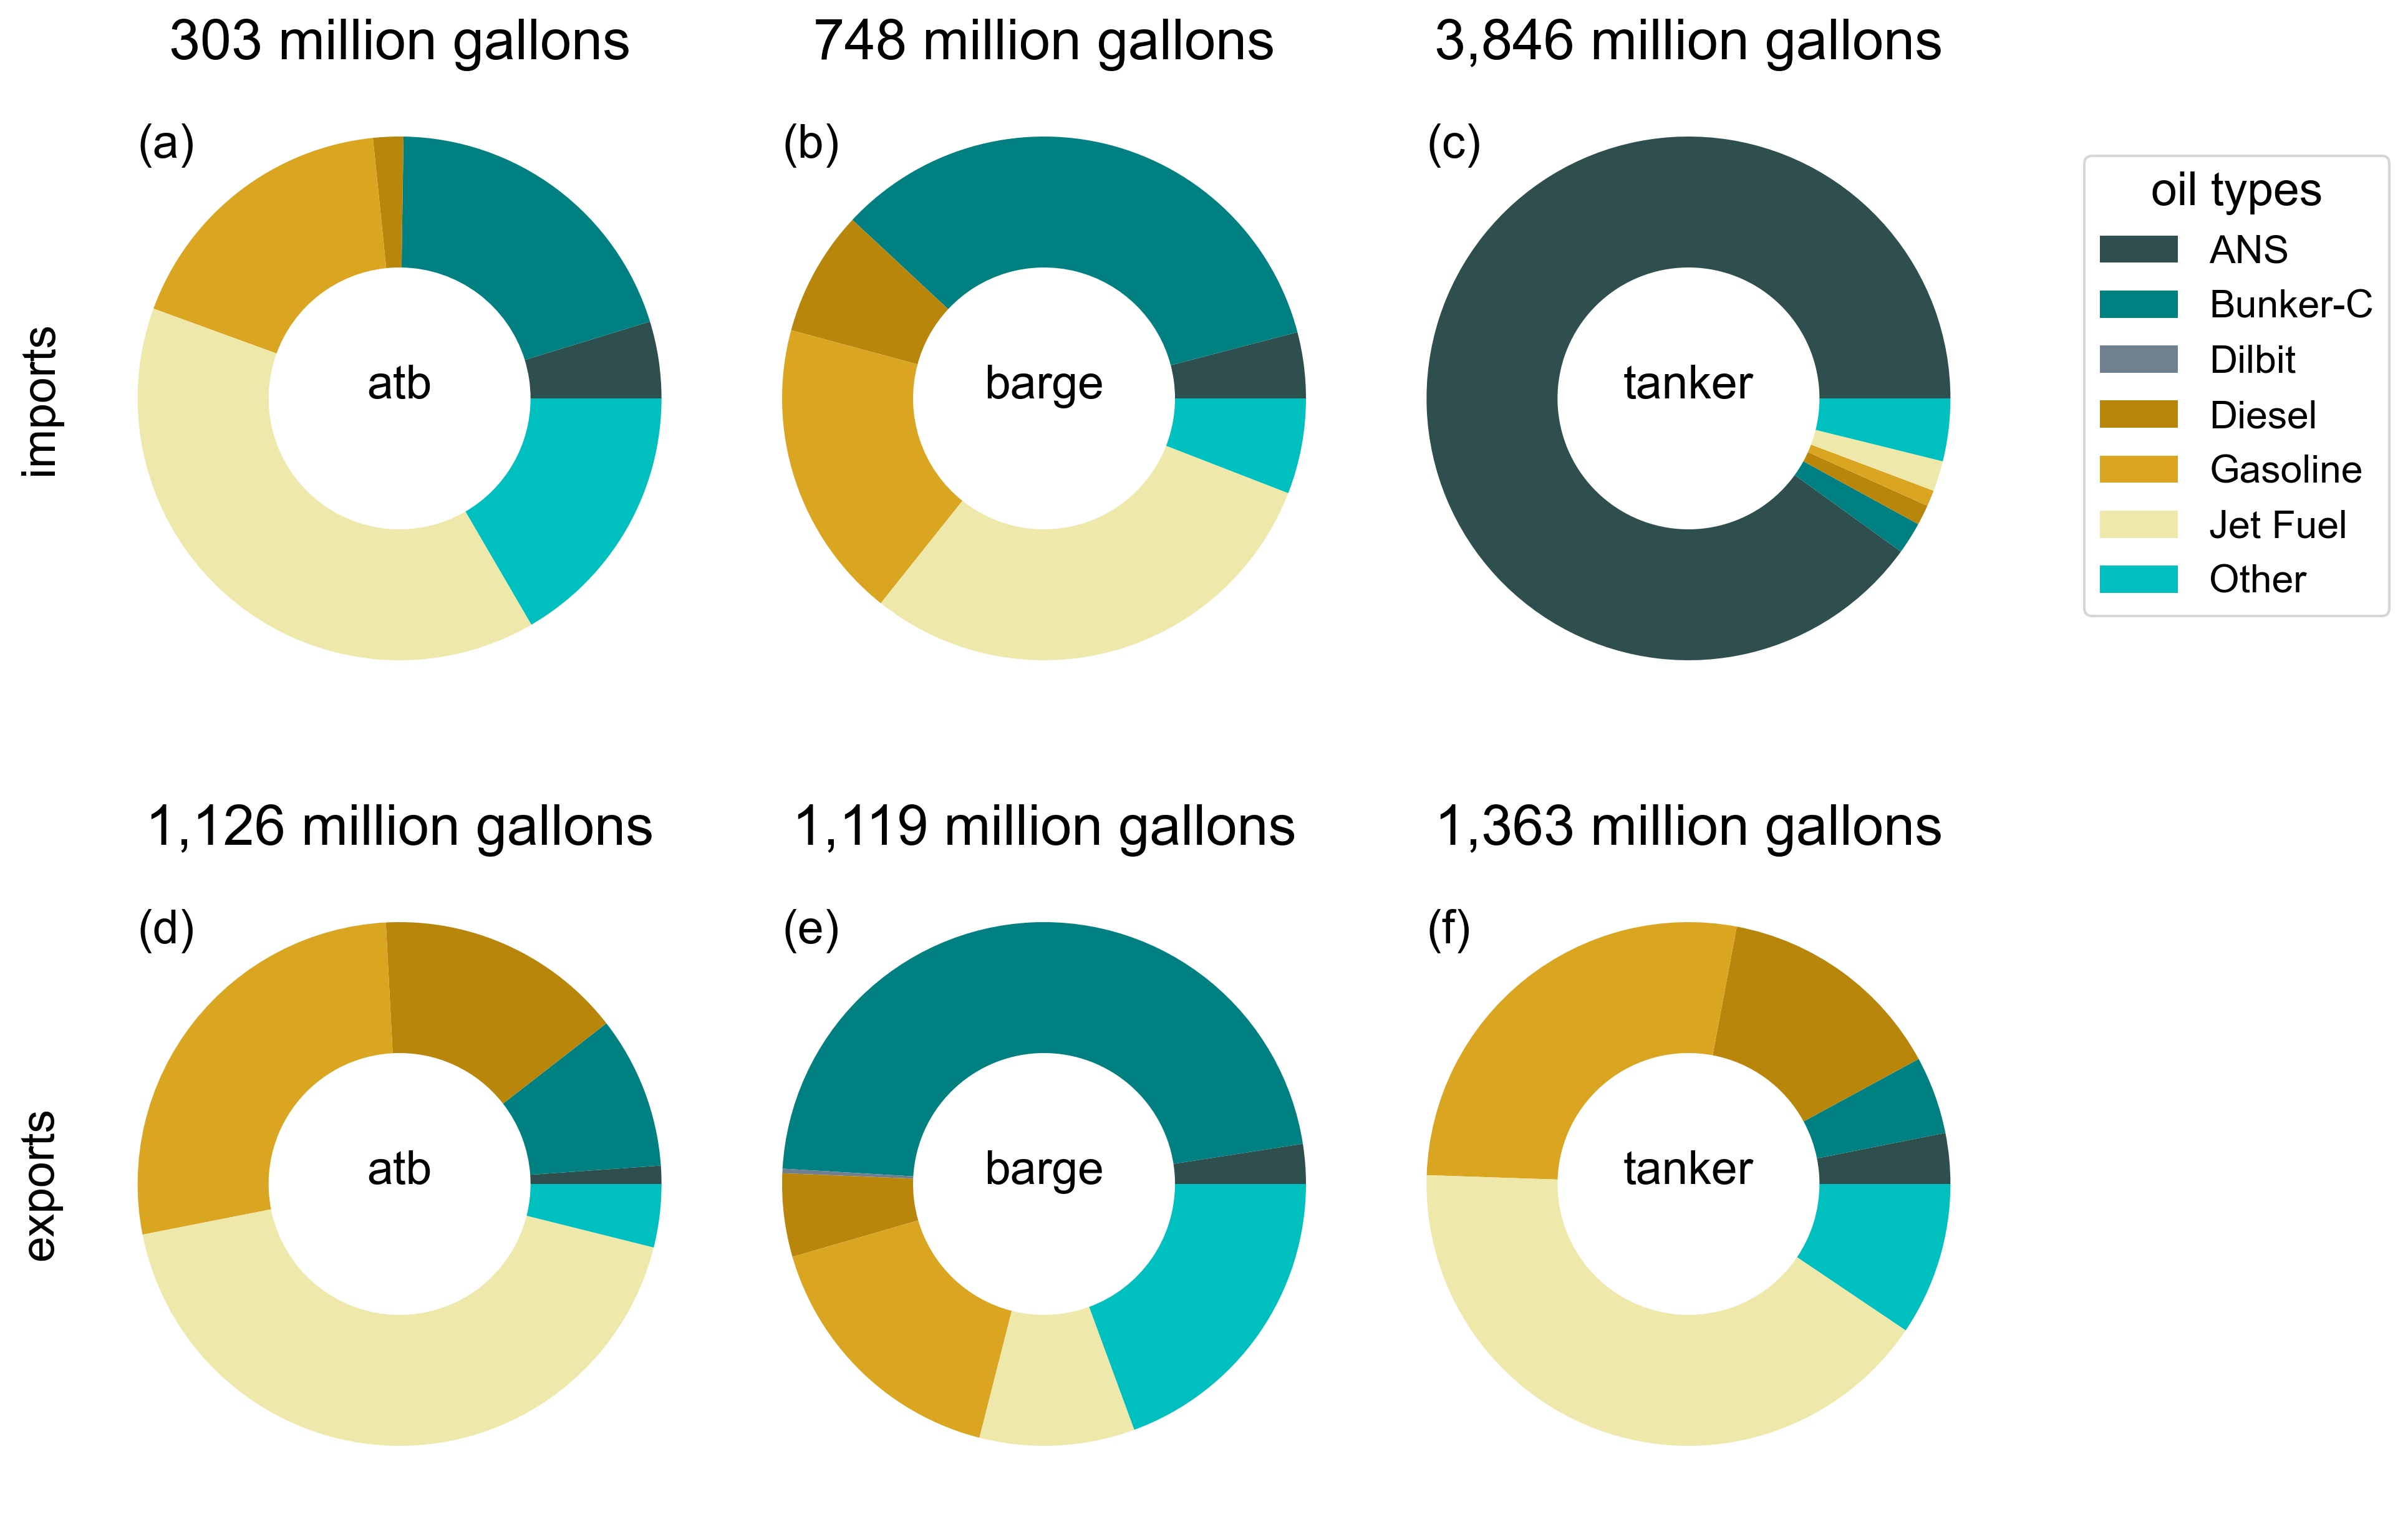

In [6]:
fig = plt.figure() 
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(10)
# set width of each subplot as 8
fig.set_figwidth(20)
fig.tight_layout
# create grid for different subplots
spec = gridspec.GridSpec(ncols=nc, nrows=2,wspace=-.6,
                         hspace=0.2,width_ratios=np.ones(nc),
                         height_ratios=[1,1])
ax={}
for ind in np.arange(nc*2):
    ax[ind] = fig.add_subplot(spec[ind])

plt.rcParams['axes.titlepad'] = -18  # pad is in points...

for j,vessel in enumerate(vessel_types):
            
    ax[j].axis('tight')
    ax[j+nc].axis('tight')
    
    # create array of total oil volume by oil type for each vessel at each facility
    plot_imports=np.array([v for v in imports[vessel].values()])
    plot_exports=np.array([v for v in exports[vessel].values()])
    # imports
    ax[j].pie(
        plot_imports, 
        wedgeprops=dict(width=0.5), 
        labels = None,
        colors=oil.colors7
    )
    # exports
    ax[j+nc].pie(
        plot_exports, 
        wedgeprops=dict(width=0.5), 
        labels = None,
        colors=oil.colors7
    )
    
    vessel = vessel_types[j]
    ax[j].set_title(f'{plot_imports.sum()/1e6:,.0f} million gallons')
    ax[j+nc].set_title(f'{plot_exports.sum()/1e6:,.0f} million gallons')
    ax[j].text(0,0,vessel,ha='center')
    ax[j+nc].text(0,0,vessel,ha='center')
           
ax[0].set_ylabel('imports')
ax[nc].set_ylabel('exports')
ax[0].text(-1,0.92,'(a)')
ax[1].text(-1,0.92,'(b)')
ax[2].text(-1,0.92,'(c)')
ax[nc].text(-1,0.92,'(d)')
ax[nc+1].text(-1,0.92,'(e)')
ax[nc+2].text(-1,0.92,'(f)')
ax[2].legend(
    bbox_to_anchor=(1.6, 0.9),
    title='oil types',
    labels = oil.labels
)
plt.savefig(graphics_directory/'Part1_Figure6a_oil_distribution_gallons.png')


# regional map

In [7]:
georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV21-08")
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV21-08")
water_mask = mesh_mask.tmaskutil.isel(time=0)
fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DPhysicsFields1hV21-11")
salinity = fields.salinity.sel(time="2020-08-14 14:30", depth=0, method="nearest").where(water_mask)

In [8]:
# define latitude bins
lat_partition = [46.9, 48.3, 48.7]
# regional tags
regions = ['Columbia River','Puget Sound','Anacortes','Whatcom County']

In [9]:
fac_df = assign_facility_region(fac_names)
fac_df.loc[fac_df['FacilityName']=='Tesoro Port Angeles Terminal', 'Region'] = 'None'

In [10]:
whatcom_fac_df    = fac_df[fac_df['Region']=='Whatcom County']
anacortes_fac_df  = fac_df[fac_df['Region']=='Anacortes']
pugetsound_fac_df = fac_df[fac_df['Region']=='Puget Sound']

In [11]:
ECY_df=get_ECY_df(
    ecy_data, 
    fac_names,  
    group='no'
)
oil_classification = get_ECY_oilclassification(
    ecy_data
)
type_description = ['TANK BARGE','TUGBOAT','TANK SHIP']
facility_names = oil_attrs['categories']['US_origin_destination']

In [12]:
# # remove Grey's Harbor and Port Angeles terminals for better North/South representation
# facility_names.remove('REG Grays Harbor, LLC')
# facility_names.remove('Tesoro Port Angeles Terminal')

In [13]:
exports_byOil={}
imports_byOil={}
for oil_type in oil.types: 
    exports_byOil[oil_type] = ECY_df.loc[
        (ECY_df.TransferType == 'Cargo') &
        (ECY_df.ReceiverTypeDescription.isin(type_description)) & 
        (ECY_df.Deliverer.isin(facility_names)) & 
        (ECY_df.Product.isin(oil_classification[oil_type])), 
        ['TransferQtyInGallon', 'ExportRegion']
    ].groupby('ExportRegion').sum()
    imports_byOil[oil_type] = ECY_df.loc[
        (ECY_df.TransferType == 'Cargo') &
        (ECY_df.DelivererTypeDescription.isin(type_description)) & 
        (ECY_df.Receiver.isin(facility_names)) & 
        (ECY_df.Product.isin(oil_classification[oil_type])), 
        ['TransferQtyInGallon', 'ImportRegion']
    ].groupby('ImportRegion').sum()

In [14]:
exports_byRegion = {}
imports_byRegion = {}
combined_byRegion = {}
for region in regions:
    exports_byRegion[region]={}
    imports_byRegion[region]={}
    combined_byRegion[region]={}
    my_list_in = []
    my_list_out = []
    for oil_type in oil.types:
        try:
            my_list_in.append(imports_byOil[oil_type]['TransferQtyInGallon'].loc[region])
            my_list_out.append(exports_byOil[oil_type]['TransferQtyInGallon'].loc[region])
        except:
            my_list_in.append(0)
            my_list_out.append(0)
    my_array_in = np.asarray(my_list_in)
    my_array_out = np.asarray(my_list_out)
    imports_byRegion[region] = pd.DataFrame (my_array_in, columns = ['Volume'], index = oil.types)
    exports_byRegion[region] = pd.DataFrame (my_array_out, columns = ['Volume'], index = oil.types)
    
    combined_byRegion[region]=imports_byRegion[region]+exports_byRegion[region]
    #combined_byRegion[region]=combined_byRegion[region]*gallons_to_liters

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

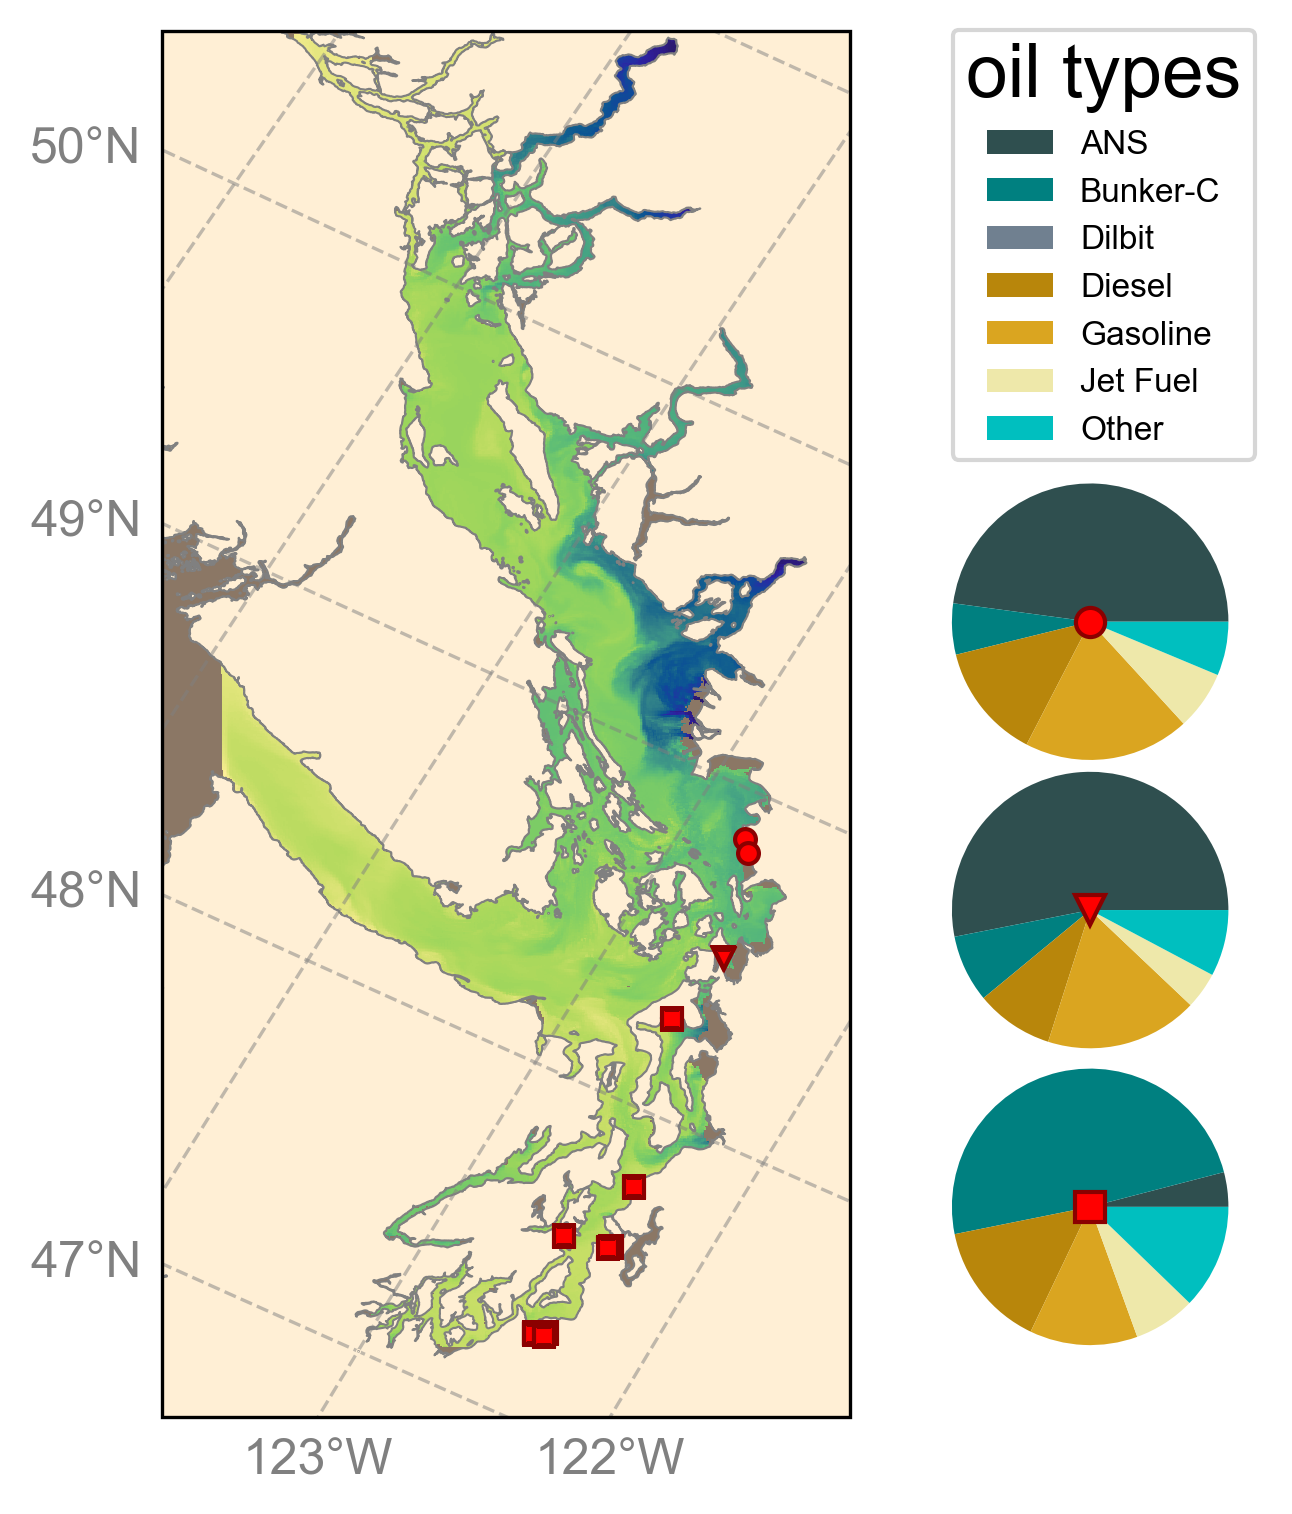

In [15]:
# disclaimer: this code was generated by a learning-in-progress human, pre-AI,  
# who later asked Gemini how to make it more user-friendly and the AI just maniacally laughed.
# it is what it is.

lat={}
lat['whatcom'] = 48.88
lat['anacortes']=48.2
lat['puget']=47.5
lon=-122.758

# the offsets needed for indexing from lower left of graphic boundary
x0 = -0.09
y0 = -0.044

# mapping specifications
rotated_crs = ccrs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = ccrs.PlateCarree()

fig,ax = plt.subplots(
    1, 1, 
    figsize=(12, 6), 
    subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)
ax.add_feature(
    cfeature.GSHHSFeature(
        'full', edgecolor='grey', linewidth = 0.5, facecolor='papayawhip')
)

quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, 
    salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)
gl = ax.gridlines(linestyle="--", color='gray', alpha=0.5, draw_labels=True, dms=True, x_inline=False, y_inline=False)
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels, gl.right_labels = False, False
gl.xlocator = mticker.FixedLocator([-126, -125, -124, -123, -122])
gl.ylocator = mticker.FixedLocator([47,48,49,50,51])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}

# calculate location of marine terminal within graphic window
scale = 1.2
#~~~~~~~~~~~~~~~~ Whatcom ~~~~~~~~~~~~~~~~~~
xleft = ((lon - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((lat['whatcom'] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_whatcom = fig.add_axes([xleft+x0, ybottom+y0,.08*scale, .2*scale])
ax_whatcom.pie(combined_byRegion['Whatcom County']['Volume'], colors = oil.colors7)

#~~~~~~~~~~~~~~~~ Puget ~~~~~~~~~~~~~~~~~~
xleft = ((lon - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((lat['puget'] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_puget = fig.add_axes([xleft+x0, ybottom+y0,.08*scale, .2*scale])
ax_puget.pie(combined_byRegion['Puget Sound']['Volume'], colors = oil.colors7)

#~~~~~~~~~~~~~~~~ ANACORTES ~~~~~~~~~~~~~~~~~~
xleft = ((lon - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((lat['anacortes'] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_anacortes = fig.add_axes([xleft+x0, ybottom+y0,.08*scale, .2*scale])
ax_anacortes.pie(combined_byRegion['Anacortes']['Volume'], colors = oil.colors7)

fig.legend(
    bbox_to_anchor=(.725, .89),
    title='oil types',
    prop={'size': 8},
    labels = oil.labels
)

# setting extent in rotated_crs was...problematic
# my inelegant hack is to add two (invisible) points to broaden extent
ax.plot(
    -123,
    47,
    '.', 
    color='papayawhip',  
    markersize=.5, 
    transform=plain_crs
)

ax.plot(
    -124.9,
    48.5,
    '.', 
    color="#8b7765", 
    markersize=.5, 
    transform=plain_crs
)
# end extent hack

marker_color = "red"
markeredge_color = 'darkred'
# plot whatcom terminal locations and legend marker
ax.plot(
    whatcom_fac_df.DockLongNumber,
    whatcom_fac_df.DockLatNumber,
    'o', 
    color=marker_color, 
    markeredgecolor=markeredge_color, 
    markersize=5, 
    transform=plain_crs
)
ax_whatcom.plot(
    0,0,
    'o', 
    color=marker_color, 
    markeredgecolor=markeredge_color, 
    markersize=7
)

# plot puget sound terminal locations and legend marker
ax.plot(
    pugetsound_fac_df.DockLongNumber,
    pugetsound_fac_df.DockLatNumber,
    's', 
    color=marker_color, 
    markeredgecolor=markeredge_color, 
    markersize=5, 
    transform=plain_crs
)

ax_puget.plot(
    0,0,
    's', 
    color=marker_color, 
    markeredgecolor=markeredge_color, 
    markersize=7
)

# plot anacortes terminal locations and legend marker
ax.plot(
    anacortes_fac_df.DockLongNumber,
    anacortes_fac_df.DockLatNumber,
    'v', 
    color=marker_color, 
    markeredgecolor=markeredge_color, 
    markersize=5, 
    transform=plain_crs
)

ax_anacortes.plot(
    0,0,
    'v', 
    color=marker_color, 
    markeredgecolor=markeredge_color, 
    markersize=7
)

#ax_north.bar(oil_types, 1e1* numpy.ones(7), width = 1)
fig.canvas.draw()

plt.savefig(graphics_directory/'Part1_Figure6b_oil_distribution.png')

In [16]:
whatcom_fac_df['FacilityName'].to_list()

['BP Cherry Point Refinery', 'Phillips 66 Ferndale Refinery']

In [17]:
anacortes_fac_df['FacilityName'].to_list()

['Shell Puget Sound Refinery', 'Marathon Anacortes Refinery (formerly Tesoro)']

In [18]:
pugetsound_fac_df['FacilityName'].to_list()

['Shell Oil LP Seattle Distribution Terminal',
 'Maxum Petroleum - Harbor Island Terminal',
 'Nustar Energy Tacoma',
 'SeaPort Sound Terminal',
 'Phillips 66 Tacoma Terminal',
 'U.S. Oil & Refining',
 'Naval Air Station Whidbey Island (NASWI)',
 'NAVSUP Manchester',
 'Alon Asphalt Company (Paramount Petroleum)',
 'Kinder Morgan Liquids Terminal - Harbor Island',
 'TLP Management Services LLC (TMS)']